# Graph Classifier

In this experiment we will use an `graph classifier`.


We use a graph with 2 node types
- The customer node with age, gender as properties
- The merchant node with category as property

And 1 edge types
- From customer to merchant, with the amount as property


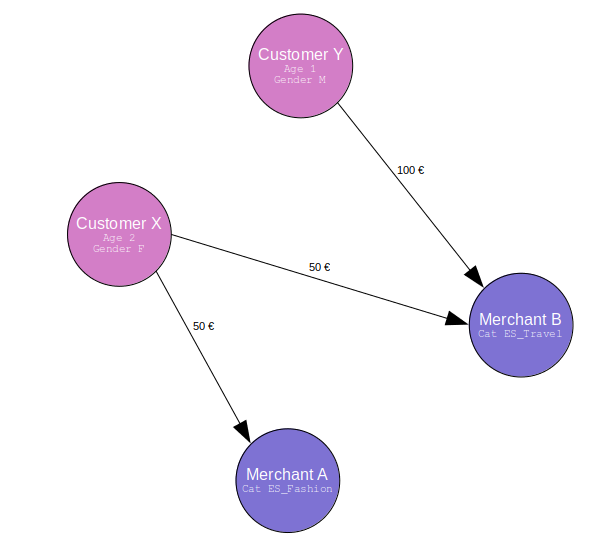

---
#### Note on the data set 
The data set used here (https://www.kaggle.com/datasets/ealaxi/banksim1) is not particularly complex and/or big. It's not really all that challenging to find the fraud. In an ideal world we'd be using more complex data sets to show the real power of Deep Learning. There are a bunch of PCA'ed data sets available, but the PCA obfuscates some of the elements that are useful. 
*These examples are meant to show the possibilities, it's not so useful to interpret their performance on this data set*

## Imports

In [1]:
import torch
import numpy as np
import pandas as pd
import gc

import datetime as dt

import d373c7.features as ft
import d373c7.engines as en
import d373c7.pytorch as pt
import d373c7.pytorch.models as pm
import d373c7.plot as pl
import d373c7.network as nw
import d373c7.pytorch.graph.geometric as geo

import torch.nn.functional as F
import torch.nn as nn

from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv, Linear, HeteroConv

from typing import Tuple

## Set a random seed for Numpy and Torch
> Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# Change this to read from another location
file = '../../../../data/bs140513_032310.csv'

## Define some Pandas dataframes we will use as input for our network
We will create one Pandas for each node-type and one pandas for each edge-type

In [4]:
def step_to_date(step_count: int):
    return dt.datetime(2020, 1, 1) + dt.timedelta(days=int(step_count))

step = ft.FeatureSource('step', ft.FEATURE_TYPE_INT_16) 
customer = ft.FeatureSource('customer', ft.FEATURE_TYPE_STRING)
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT_32)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

payment_id = ft.FeatureSource('payment_id', ft.FEATURE_TYPE_INT_32)
customer_id = ft.FeatureSource('customer_id', ft.FEATURE_TYPE_INT_32)
merchant_id = ft.FeatureSource('merchant_id', ft.FEATURE_TYPE_INT_32)

age_oh = ft.FeatureOneHot('age_oh', ft.FEATURE_TYPE_INT_8, age)
gender_oh = ft.FeatureOneHot('gender_oh', ft.FEATURE_TYPE_INT_8, gender)
category_oh = ft.FeatureOneHot('category_oh', ft.FEATURE_TYPE_INT_8, category)

amount_scale = ft.FeatureNormalizeScale('amount_scale', ft.FEATURE_TYPE_FLOAT_32, amount)

date_time = ft.FeatureExpression('date', ft.FEATURE_TYPE_DATE_TIME, step_to_date, [step])

raw_td = ft.TensorDefinition(
    'raw',
    [
        step,
        customer,
        age,
        gender,
        merchant,
        category,
        amount,
        fraud
    ])

label_td = ft.TensorDefinition(
    'labels',
    [fraud]
)

customer_node_td = ft.TensorDefinition(
    'customer_node', 
    [
        customer_id,
        age_oh,
        gender_oh
    ])

merchant_node_td = ft.TensorDefinition(
    'merchant_node', 
    [
        merchant_id,
        category_oh
    ])

customer_to_merchant_edge_td = ft.TensorDefinition(
    'customer_to_payment_edge', 
    [
        customer_id,
        merchant_id,
        amount_scale,
        date_time
    ])

with en.EnginePandasNumpy(num_threads=1) as e:
    df_raw = e.from_csv(raw_td, file, inference=False)
    
# Add unique index to the payment df.
df_raw['payment_id'] = df_raw.index

# Add a unique id per each customer and merchant
df_raw['customer_id'] = pd.factorize(df_raw['customer'])[0]
df_raw['merchant_id'] = pd.factorize(df_raw['merchant'])[0]

with en.EnginePandasNumpy(num_threads=1) as e:
    df_cn = e.from_df(customer_node_td, df_raw, raw_td, inference=False)
    df_mn = e.from_df(merchant_node_td, df_raw, raw_td, inference=False)
    df_cme = e.from_df(customer_to_merchant_edge_td, df_raw, raw_td, inference=False)
    df_labels = e.from_df(label_td, df_raw, raw_td, inference=False)

# Make customer and merchant data unique
df_cn = df_cn.drop_duplicates(subset=['customer_id'])
df_mn = df_mn.drop_duplicates(subset=['merchant_id'])

# Labels to numpy
labels = df_labels.to_numpy()

2022-07-10 19:39:56.806 d373c7.engines.common          INFO     Start Engine...
2022-07-10 19:39:56.806 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2022-07-10 19:39:56.806 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2022-07-10 19:39:56.807 d373c7.engines.panda_numpy     INFO     Building Panda for : raw from file ../../../../data/bs140513_032310.csv
2022-07-10 19:39:57.012 d373c7.engines.panda_numpy     INFO     Building Panda for : <Built Features> from DataFrame. Inference mode <False>
2022-07-10 19:39:57.013 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Built Features
2022-07-10 19:39:57.018 d373c7.engines.panda_numpy     INFO     Done creating Built Features. Shape=(594643, 8)
2022-07-10 19:39:57.019 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: raw
2022-07-10 19:39:57.057 d373c7.engines.common          INFO     Start Engine...
2022-07-10 19:39:57.058 d373c7.engines.panda_numpy     INFO     Pandas Version : 1

In [5]:
df_cme = df_cme[0:10000]

### Define a network structure

In [6]:
# Define Nodes
customer_node = nw.NetworkNodeDefinitionPandas('customer', customer_id, customer_node_td, df_cn)
merchant_node = nw.NetworkNodeDefinitionPandas('merchant', merchant_id, merchant_node_td, df_mn)

# Define Edges
customer_to_merchant_edge = nw.NetworkEdgeDefinitionPandas(
    name = 'customer_to_merchant',
    id_feature = payment_id,
    from_node = customer_node,
    from_node_id = customer_id,
    to_node = merchant_node,
    to_node_id = merchant_id,
    td = customer_to_merchant_edge_td,
    df = df_cme
)

# Now define the network
network = nw.NetworkDefinitionPandas(
    'network', 
    [customer_node, merchant_node], 
    [customer_to_merchant_edge]
)

In [7]:
with en.EnginePandasNumpy(num_threads=1) as e:
    ego = e.to_networks_ego(network, date_time, [ft.TensorDefinition('', [])], 3)

2022-07-10 19:40:04.628 d373c7.engines.common          INFO     Start Engine...
2022-07-10 19:40:04.628 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2022-07-10 19:40:04.628 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2


In [8]:
print(ego[0][0].shape)

(21373873,)


In [9]:
print(ego[0][0])

[   0    1    1 ... 9999 9999 9999]


In [10]:
x=ego[0][0] == 9999

In [11]:
print(np.count_nonzero(x))

2766


In [12]:
print(df_cme.iloc[9999])

customer_id                    1504
merchant_id                       0
amount_scale              0.0071573
date            2020-01-05 00:00:00
Name: 9999, dtype: object
